<h1>Weater Classification Machine learning Model</h1>
<b>Homework</b>
<p>Use the Data from "weather_Data.csv to create a Machine Learning Model that predicts the Type of wheater</p>
<ol>
Steps
<li>Break up all cathegorial Variables except Weather Type</li>
<lI>Check Distribution</lI>
<li> Try to optimaize, by checking correlation aswell</li>
<li>Create A ANN model</li></ol>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [43]:
#load Data
df=pd.read_csv("weather_Data.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [44]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [45]:
df.duplicated().sum()

0

In [46]:
for column in df.columns:
    number_of_distinct_values = len(df[column].unique())
    print(f"{column}: {number_of_distinct_values} distinct values")

Temperature: 126 distinct values
Humidity: 90 distinct values
Wind Speed: 97 distinct values
Precipitation (%): 110 distinct values
Cloud Cover: 4 distinct values
Atmospheric Pressure: 5456 distinct values
UV Index: 15 distinct values
Season: 4 distinct values
Visibility (km): 41 distinct values
Location: 3 distinct values
Weather Type: 4 distinct values


<ul>
<li>Weater Type = 4 Distinc Values , Focus on</li>
<li>Cloud Coverage: 4 Values</li>
<li>Season 4 Values</li>
<li>Location 3 Values</li>
<p>If breaking up all those Values with onehot encoding 5 Columns would be added this is reasonable, but maybe there is a better way, we will check</p>
</ul>

In [47]:
#rename Variables to have no whitespace
df.rename(columns={'Wind Speed': 'WindSpeed'}, inplace=True)
df.rename(columns={'Cloud Cover': 'CloudCover'}, inplace=True)
df.rename(columns={'Atmospheric Pressure': 'Pressure'}, inplace=True)
df.rename(columns={'UV Index': 'UV'}, inplace=True)
df.rename(columns={'Visibility (km)': 'Visibility'}, inplace=True)
df.rename(columns={'Weather Type': 'Type'}, inplace=True)
df.rename(columns={'Precipitation (%)': 'Precipitation'}, inplace=True)

In [48]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder
variables = ['Season','Location']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [49]:
cloud_cover_mapping = {'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3}
df['CloudCover_Encoded'] = df['CloudCover'].map(cloud_cover_mapping)
df = df.drop('CloudCover', axis=1)
# Rename the encoded column to CloudCover
df = df.rename(columns={'CloudCover_Encoded': 'CloudCover'})

# Mapping numerical values to descriptive labels for CloudCover
#df['CloudCover'] = df['CloudCover'].replace({0: 'clear', 1: 'partly cloudy', 2: 'cloudy', 3: 'overcast'})


df = df.drop('Season_Autumn', axis=1)
df = df.drop('Location_coastal', axis=1)

In [50]:
df.head()

,Temperature,Humidity,WindSpeed,Precipitation (%),Pressure,UV,Visibility,Type,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain,CloudCover
0,14.0,73,9.5,82.0,1010.82,2,3.5,Rainy,0,0,1,1,0,1
1,39.0,96,8.5,71.0,1011.43,7,10.0,Cloudy,1,0,0,1,0,1
2,30.0,64,7.0,16.0,1018.72,5,5.5,Sunny,1,0,0,0,1,0
3,38.0,83,1.5,82.0,1026.25,7,1.0,Sunny,1,0,0,0,0,0
4,27.0,74,17.0,66.0,990.67,1,2.5,Rainy,0,0,1,0,1,3


<h4>X/Y</h4>

In [51]:
# everything else except the target variable
X = df.drop(["Type"], axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Type']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

#seperate df for the corr function
yf=df
yf['Type']=y_enc

<h3>Analytic</h3>
<p>I will shamelessly just use the Reports.ipynb file from the AdDA HW again to get some basic stats</p>

In [54]:
df['Type'].value_counts().sort_index()


Type
0    3300
1    3300
2    3300
3    3300
Name: count, dtype: int64

<p>Every Typ has Exactly 3300 this does look like artifically made Data, but also means there is no need for grouping</p>

<b>Quick checklist</b>
<ol><li>Correlation</li><LI>Distribution</LI><li>Outliers</li></ol>

In [53]:
correlations=df.corr()['Type']
correlations.sort_values(ascending=False)

Type                 1.000000
UV                   0.345804
Season_Winter        0.135562
Visibility           0.047448
Location_mountain    0.045542
Pressure             0.030679
Temperature          0.028923
Location_inland      0.026744
Season_Summer       -0.045884
Season_Spring       -0.067318
Precipitation (%)   -0.161578
WindSpeed           -0.166485
Humidity            -0.250558
CloudCover          -0.370412
Name: Type, dtype: float64

<b>Under 0.0 (excpet onehot encoded)</b>
<ul>
<li>Visibility</li>
<li>Pressure</li>
<li>Temperatur</li>
</ul>

<b>Fisher's lowest</b>
<ul><li>Humidity</li><li>Cloud_Cover</li><li>Precepitation</li></ul>

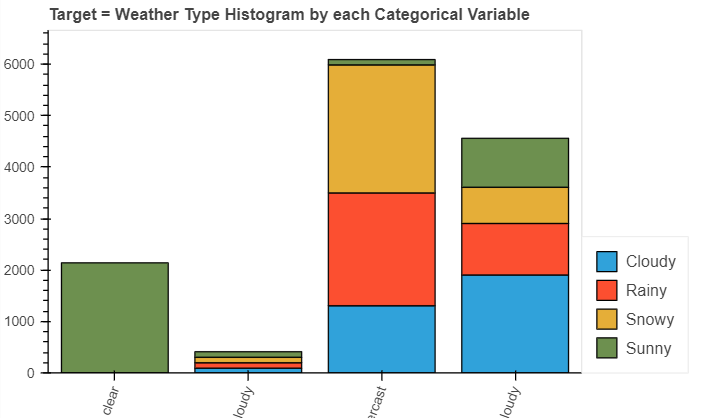
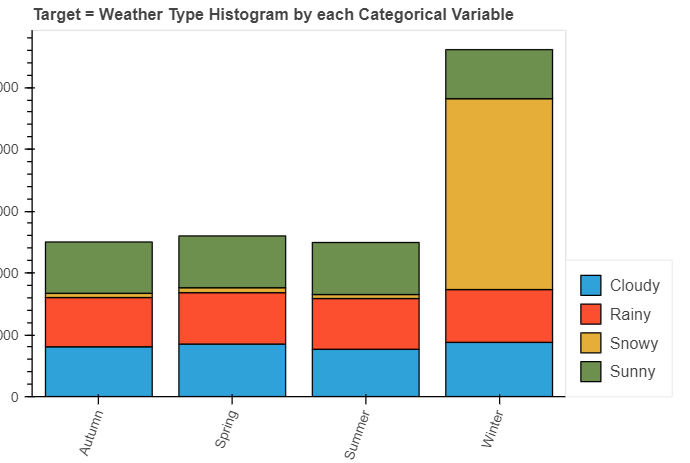
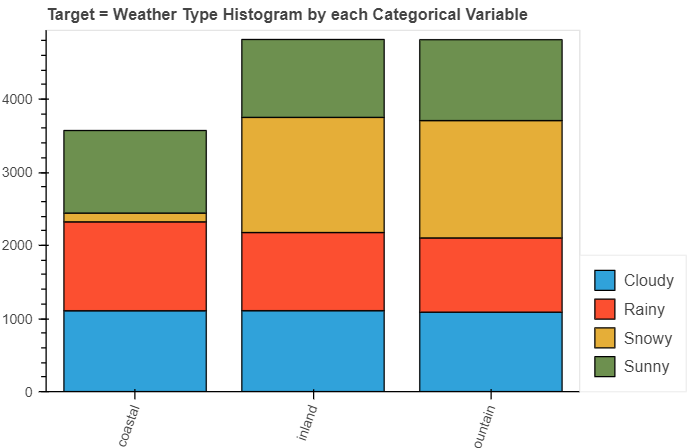
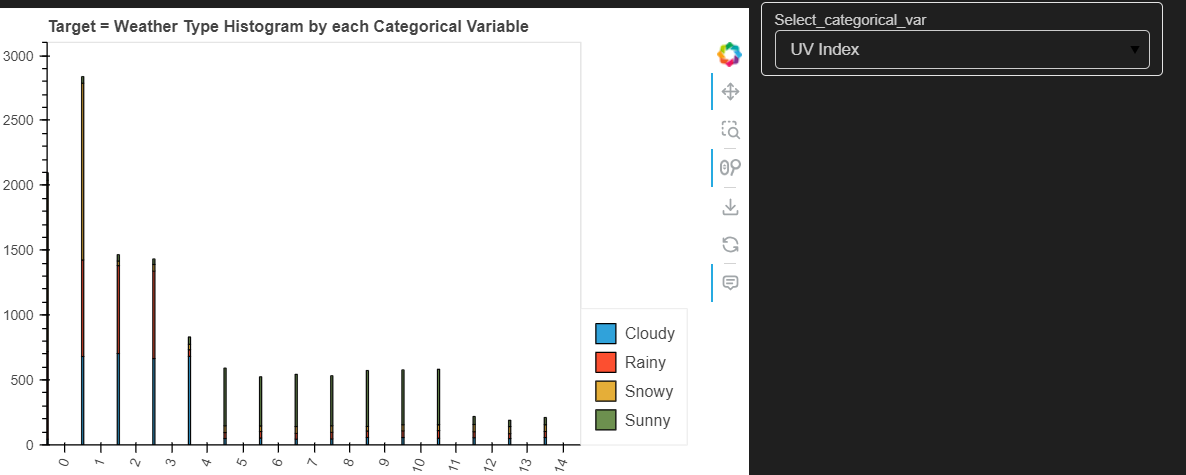